<a href="https://colab.research.google.com/github/ayulockin/LossLandscape/blob/master/Visualizing_Function_Space_Similarity_SmallCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setups, Imports and Installations

In [1]:
## This is so that I can save my models.
from google.colab import drive
drive.mount('gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at gdrive


In [2]:
%%capture
!pip install wandb

In [3]:
# SEED = 666

import tensorflow as tf
# tf.random.set_seed(SEED)

from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import resnet50

import tensorflow_addons as tfa

In [182]:
import os
os.environ["TF_DETERMINISTIC_OPS"] = "1"

import numpy as np
from numpy.linalg import norm
# np.random.seed(SEED)

import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns
sns.set()

from tqdm.notebook import tqdm_notebook

In [5]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Get Trained Models

(For now I am using models trained from SmallCNN.)

In [195]:
## SmallCNN model checkpoint for each epoch(total 40 epochs)
MODEL_PATH = 'gdrive/My Drive/LossLandscape/SmallCNN_CheckpointID/'

In [196]:
model_ckpts = os.listdir(MODEL_PATH)
print(len(model_ckpts))

40 40


# Get Dataset and Prepare

#### CIFAR-10

In [21]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

y_train = y_train.flatten()
y_test = y_test.flatten()

CLASS_NAMES = ("airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)


#### Dataloader

In [38]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 128
IMG_SHAPE = 32

trainloader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
testloader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

def preprocess_image(image, label):
  img = tf.cast(image, tf.float32)
  img = img/255.

  return img, label

trainloader = (
    trainloader
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

testloader = (
    testloader
    .map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

#   Similarity of Functions Within Initialized Trajectories

## Disagreement of predictions 

(Refer figure 2(b) from paper)

In [34]:
def evaluate(test_dataloader, model):
  true_labels = []
  pred_labels = []
  
  for imgs, labels in iter(test_dataloader):
    preds = model.predict(imgs)
    
    true_labels.extend(labels)
    pred_labels.extend(np.argmax(preds, axis=1))

  return np.array(true_labels), np.array(pred_labels)

In [52]:
predictions = []
for i in tqdm_notebook(range(40)):
  # load model
  model = tf.keras.models.load_model(MODEL_PATH+model_ckpts[i])
  # get predictions for model
  _, preds = evaluate(testloader, model)

  predictions.append(preds)

In [85]:
empty_arr = np.zeros(shape=(40,40))
empty_arr.shape

(40, 40)

In [98]:
for i in tqdm_notebook(range(40)):
  preds1 = predictions[i]
  for j in range(i, 40):
    preds2 = predictions[j]
    
    # compute dissimilarity
    dissimilarity_score = 1-np.sum(np.equal(preds1, preds2))/10000 
    
    empty_arr[i][j] = dissimilarity_score
    if i is not j:
      empty_arr[j][i] = dissimilarity_score

In [99]:
dissimilarity_coeff = empty_arr[::-1]

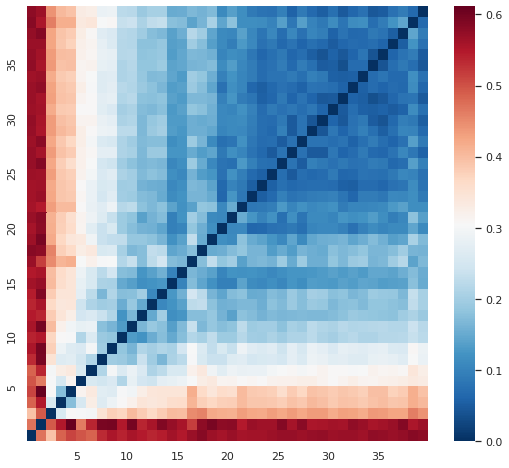

In [118]:
plt.figure(figsize=(9,8))
sns.heatmap(dissimilarity_coeff, cmap='RdBu_r');
plt.xticks([5,10,15,20,25,30,35],[5,10,15,20,25,30,35]);
plt.yticks([5,10,15,20,25,30,35],[35,30,25,20,15,10,5]);

## Cosine Similarity of weights

In [170]:
def get_model_weights(model):
  model_weights = []
  for layer in model.layers:
    weights = layer.get_weights()
    if len(weights)==0:
      continue

    model_weights.extend(np.array(weights[0]).flatten())

  return np.array(model_weights)

In [171]:
weights_of_models = []
for i in tqdm_notebook(range(40)):
  # load model
  model = tf.keras.models.load_model(MODEL_PATH+model_ckpts[i])
  # get predictions for model
  weights = get_model_weights(model)

  weights_of_models.append(weights)

In [172]:
empty_arr = np.zeros(shape=(40,40))
empty_arr.shape

(40, 40)

In [183]:
for i in tqdm_notebook(range(40)):
  weights1 = weights_of_models[i]
  for j in range(i, 40):
    weights2 = weights_of_models[j]
    
    # compute cosine similarity of weights
    cos_sim = np.dot(weights1, weights2)/(norm(weights1)*norm(weights2))
    
    empty_arr[i][j] = cos_sim
    if i is not j:
      empty_arr[j][i] = cos_sim

In [184]:
cos_sim_coeff = empty_arr[::-1]

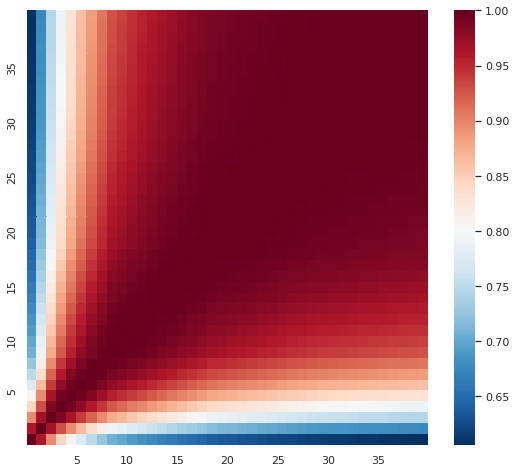

In [186]:
plt.figure(figsize=(9,8))
sns.heatmap(cos_sim_coeff, cmap='RdBu_r');
plt.xticks([5,10,15,20,25,30,35],[5,10,15,20,25,30,35]);
plt.yticks([5,10,15,20,25,30,35],[35,30,25,20,15,10,5]);

# Similarity of Functions Across Randomly Initialized Tragectories

## Disagreement of predictions